In [1]:
# Data manipulation
import pandas as pd
import numpy as np

import pandas_ta as ta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Model creation
import tensorflow as tf
from keras.layers import *
from keras.models import Sequential
from keras.regularizers import l1, l2
from keras.optimizers import Adam
from keras.optimizers import Adam
#pip install zigzag
from zigzag import *

# load data
import yfinance as yf

2024-03-14 16:44:38.073259: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-14 16:44:38.438646: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-14 16:44:38.443267: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-14 16:44:43.921694: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Data download
symbol = "EURUSD=X"
period ='60d'
interval ='1h'

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

In [4]:
'''
https://www.marketcalls.in/machine-learning/decoding-features-and-targets-in-machine-learning-the-keys-to-model-success.html
In machine learning, features represent the input data points or independent variables used to describe various aspects of the object under study. Targets, on the other hand, are the output or dependent variables that the model aims to predict or classify based on the input features.

https://algofin.substack.com/p/algorithmic-trading-models-machine
'''

'\nhttps://www.marketcalls.in/machine-learning/decoding-features-and-targets-in-machine-learning-the-keys-to-model-success.html\nIn machine learning, features represent the input data points or independent variables used to describe various aspects of the object under study. Targets, on the other hand, are the output or dependent variables that the model aims to predict or classify based on the input features.\n\nhttps://algofin.substack.com/p/algorithmic-trading-models-machine\n'

[*********************100%***********************]  1 of 1 completed
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0


,Open,High,Low,Close,Adj Close,returns,Min/Max Points,target
Datetime,,,,,,,,
2023-12-22 01:00:00+00:00,1.100715,1.100958,1.099989,1.100110,1.100110,-0.00055,1.0,-1
2023-12-22 02:00:00+00:00,1.100231,1.100352,1.099868,1.100352,1.100352,0.00022,0.0,-1
2023-12-22 03:00:00+00:00,1.100231,1.100837,1.099989,1.100110,1.100110,-0.00022,0.0,-1
2023-12-22 04:00:00+00:00,1.100110,1.100594,1.100110,1.100352,1.100352,0.00022,0.0,-1
2023-12-22 05:00:00+00:00,1.100231,1.100231,1.099868,1.099989,1.099989,-0.00033,0.0,-1


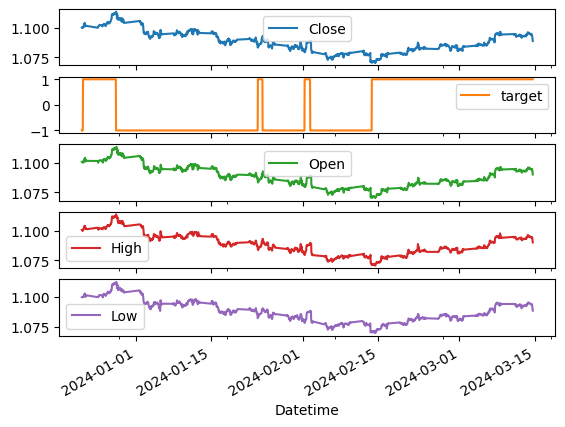

In [5]:
# load data
def get_yfinance_hist(symbol = "EURUSD=X", period ='1mo', interval ='15m', show_plot = True ):
    df_raw = yf.download(symbol,period= period ,interval=interval)
    df_raw["returns"] = np.log(df_raw.Close.div(df_raw.Close.shift(1)))
    df_raw.dropna(how="any",inplace=True)
    df_raw = df_raw.drop('Volume', axis=1)

    #Convert data into numpy array
    closing_prices = np.asarray(df_raw['Close'])

    #Calculate min/max points
    min_max_points = peak_valley_pivots(closing_prices, 0.008,-0.008)

    #Add as a column to the original df2
    df_raw['Min/Max Points'] = min_max_points

    #Replace all 0s with NaN values
    df_raw['Min/Max Points'] = df_raw['Min/Max Points'].replace(0,np.NaN)#Interpolate

    df_raw['target'] = 0
    lastValue = 0
    df_raw['Min/Max Points'].fillna(0, inplace=True)
    for i, row in df_raw.iterrows():
        if row['Min/Max Points'] != 0:
            print(row['Min/Max Points'])
            
            if(row['Min/Max Points'] == -1):
              lastValue = 1
        
            if(row['Min/Max Points'] == 1):
              lastValue = -1
        
        df_raw.at[i,'target'] = lastValue


    if(show_plot):
      plot_cols = ['Close', 'target', 'Open', 'High', 'Low']
      plot_features = df_raw[plot_cols]
      plot_features.index = df_raw.index
      _ = plot_features.plot(subplots=True)

    df_raw = df_raw.dropna()

    return df_raw

df = get_yfinance_hist(symbol = symbol, period = period, interval= interval )

df.head()

In [6]:
df.head()

,Open,High,Low,Close,Adj Close,returns,Min/Max Points,target
Datetime,,,,,,,,
2023-12-22 01:00:00+00:00,1.100715,1.100958,1.099989,1.100110,1.100110,-0.00055,1.0,-1
2023-12-22 02:00:00+00:00,1.100231,1.100352,1.099868,1.100352,1.100352,0.00022,0.0,-1
2023-12-22 03:00:00+00:00,1.100231,1.100837,1.099989,1.100110,1.100110,-0.00022,0.0,-1
2023-12-22 04:00:00+00:00,1.100110,1.100594,1.100110,1.100352,1.100352,0.00022,0.0,-1
2023-12-22 05:00:00+00:00,1.100231,1.100231,1.099868,1.099989,1.099989,-0.00033,0.0,-1


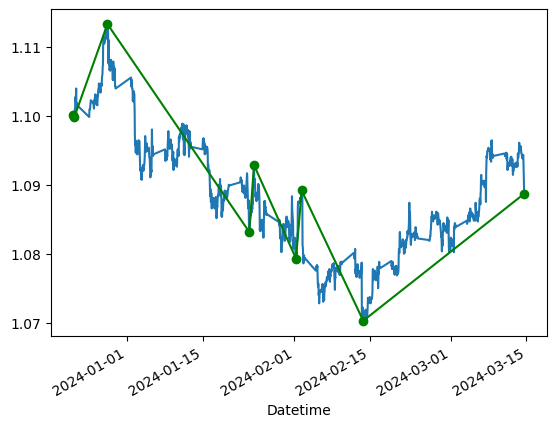

In [7]:
X = df.Close
pivots = peak_valley_pivots(X.values, 0.008, -0.008)
ts_pivots = pd.Series(X, index=X.index)
ts_pivots = ts_pivots[pivots != 0]
X.plot()
ts_pivots.plot(style='g-o');

In [8]:
def add_signal_indicators(df):
    df['SMA_10'] = ta.sma(df['Adj Close'],length=10)
    df['SMA_30'] = ta.sma(df['Adj Close'],length=30)
    df['SMA_50'] = ta.sma(df['Adj Close'],length=50)
    df['SMA_200'] = ta.sma(df['Adj Close'],length=200)
    
    macd = ta.macd(df['Adj Close'], fast=12, slow=26, signal=9)
    df['MACD'] = macd['MACD_12_26_9']
    df['MACD_signal'] = macd['MACDs_12_26_9']
    df['MACD_hist'] = macd['MACDh_12_26_9']

    df['10_cross_30'] = np.where(df['SMA_10'] > df['SMA_30'], 1, 0)
    
    df['MACD_Signal_MACD'] = np.where(df['MACD_signal'] < df['MACD'], 1, 0)
    
    df['MACD_lim'] = np.where(df['MACD']>0, 1, 0)
    
    df['abv_50'] = np.where((df['SMA_30']>df['SMA_50'])
                            &(df['SMA_10']>df['SMA_50']), 1, 0)
                            
    df['abv_200'] = np.where((df['SMA_30']>df['SMA_200'])
                            &(df['SMA_10']>df['SMA_200'])
                            &(df['SMA_50']>df['SMA_200']), 1, 0)
    
    return df

df = add_signal_indicators(df)

In [9]:
cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'returns',
       'Min/Max Points', 'SMA_10', 'SMA_30', 'SMA_50', 'SMA_200',
       'MACD', 'MACD_signal', 'MACD_hist', '10_cross_30', 'MACD_Signal_MACD',
       'MACD_lim', 'abv_50', 'abv_200']

def get_data_scaled(df, cols):
        ss = StandardScaler() #standardizing the data
        X = ss.fit_transform(df[cols])
    
        return X



X = get_data_scaled(df, cols)
X_train, X_test, y_train, y_test = train_test_split(X,df.target) #splitting dataset into 2 halves

In [41]:
optimizer = Adam(lr = 0.0001)
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.regularizers import l1, l2
from keras.optimizers import Adam

def set_seeds(seed = 100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
def cw(df):
    c0, c1 = np.bincount(df["target"])
    w0 = (1/c0) * (len(df)) / 2
    w1 = (1/c1) * (len(df)) / 2
    return {0:w0, 1:w1}

def create_model(cols):
    optimizer = Adam(learning_rate=0.001)
    model = Sequential([
    Dense(len(cols) * 6, activation="relu", input_shape=(len(cols),)),

    Dense(len(cols) * 9, activation="relu"),

    Dense(len(cols) * 12, activation="relu"),

    Dense(len(cols), activation="relu"),

    Dense(int(len(cols) / 2), activation="relu"),

    Dense(int(len(cols) / 3), activation="relu"),

    Dense(int(len(cols) / 4), activation="relu"),

    Dense(int(len(cols) / 5), activation="relu"),

    Dense(int(len(cols) / 6), activation="relu"),

    Dense(len(cols), activation="relu"),
    Dense(1)
    ])

    #model.add(Dense(1, use_bias=True, activation = "relu"))

    #print(model.summary())

    #model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=['acc', 'mse'])
    model.compile(loss=tf.keras.losses.mae, # change the loss function to be regression-specific
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])
    return model


/home/mik/anaconda3/envs/tensor/lib/python3.8/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [38]:
cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'returns',
       'Min/Max Points', 'SMA_10', 'SMA_30', 'SMA_50', 'SMA_200',
       'MACD', 'MACD_signal', 'MACD_hist', '10_cross_30', 'MACD_Signal_MACD',
       'MACD_lim', 'abv_50', 'abv_200']

train_df, val_df, test_df = np.split(df.sample(frac=1, random_state=42),
                       [int(.6*len(df)), int(.8*len(df))])
X_cols = df.columns.drop('target')
y_cols = 'target'

df_X_train = train_df[X_cols]
df_y_train = train_df[y_cols]

df_X_val = val_df[X_cols]
df_y_val = val_df[y_cols]

df_X_test = test_df[X_cols]
df_y_test = test_df[y_cols]



In [42]:

model = create_model(cols)
model.fit(x = df_X_train, y = df_y_train, epochs = 50, verbose = False, validation_split = 0.2, shuffle = False)

In [45]:
# 1. Create the model (this time 3 layers)
model = tf.keras.Sequential([
  # Before TensorFlow 2.7.0
  # tf.keras.layers.Dense(100), # add 100 dense neurons

  # With TensorFlow 2.7.0
  # tf.keras.layers.Dense(100, input_shape=(None, 1)), # add 100 dense neurons

  ## After TensorFlow 2.8.0 ##
  tf.keras.layers.Dense(100), # add 100 dense neurons
  tf.keras.layers.Dense(10), # add another layer with 10 neurons
  tf.keras.layers.Dense(1)
])

# 2. Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(), # use Adam instead of SGD
                metrics=['accuracy'])

# 3. Fit the model
model.fit(df_X_train, df_y_train, epochs=100, verbose=1) # fit for 100 passes of the data

Epoch 1/100
27/27 [==============================] - 5s 13ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 0s 18ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 3/100
27/27 [==============================] - 1s 26ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 4/100
27/27 [==============================] - 1s 19ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 5/100
27/27 [==============================] - 0s 15ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 6/100
27/27 [==============================] - 1s 21ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 7/100
27/27 [==============================] - 1s 25ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 8/100
27/27 [==============================] - 1s 34ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 9/100
27/27 [==============================] - 0s 17ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 10/100
27/27 [==============================] - 1s 36ms/step - loss: nan - accuracy: 

In [46]:
test_loss = model.evaluate(df_X_train, df_y_train)

#print("Test accuracy", test_acc)
#print("Test loss", test_loss)

27/27 [==============================] - 1s 9ms/step - loss: nan - accuracy: 0.0000e+00


In [47]:
test_loss

[nan, 0.0]

In [ ]:
loss1, acc1, mse1 = model.evaluate(X_test, y_test)
print(f"Loss is {loss1},\nAccuracy is {acc1*100},\nMSE is {mse1}")

11/11 [==============================] - 0s 14ms/step - loss: nan - acc: 0.0000e+00 - mse: nan
Loss is nan,
Accuracy is 0.0,
MSE is nan


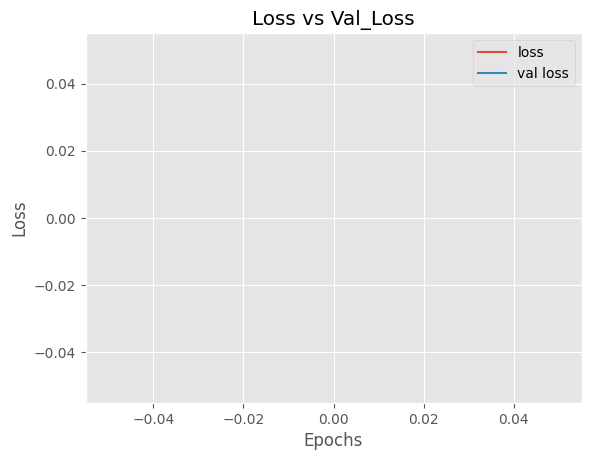

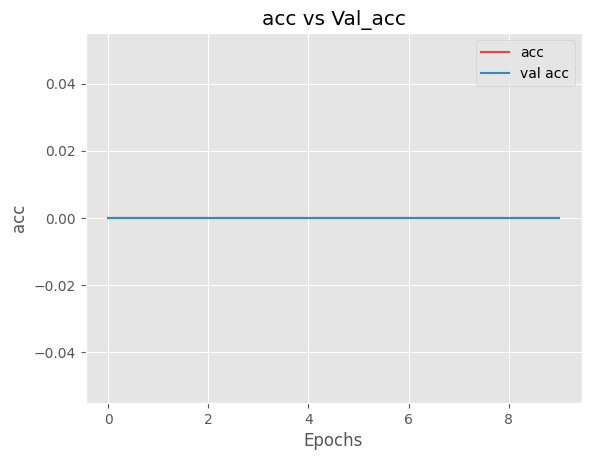

In [ ]:
plt.style.use('ggplot')
plt.plot(model_history.history['loss'], label = 'loss')
plt.plot(model_history.history['val_loss'], label='val loss')
plt.title("Loss vs Val_Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


plt.plot(model_history.history['acc'], label = 'acc')
plt.plot(model_history.history['val_acc'], label='val acc')
plt.title("acc vs Val_acc")
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.legend()
plt.show()